### Transfer Learning : Scaling Up

In [1]:
!wget https://raw.githubusercontent.com/ishan-0611/Deep-Learning/main/helper_functions.py

--2024-02-17 12:59:51--  https://raw.githubusercontent.com/ishan-0611/Deep-Learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-17 12:59:52 (103 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import unzip_data, create_tensorboard_callback, compare_historys, plot_loss_curves

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

--2024-02-17 13:01:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  22.7MB/s    in 69s     

2024-02-17 13:02:09 (22.5 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                image_size=IMG_SIZE,
                                                                                label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


More specifically, our goal will be to see if we can beat the baseline from original Food101 paper (50.76% accuracy on 101 classes) with 10% of the training data and the following modelling setup:

* A ModelCheckpoint callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
* Data augmentation built right into the model
A headless (no top layers) EfficientNetB0 architecture from tf.keras.applications as our base model
* A Dense layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
Categorical crossentropy as the loss function since we're dealing with more than two classes
* The Adam optimizer with the default settings
* Fitting for 5 full passes on the training data while evaluating on 15% of the test data

In [7]:
# Create checkpoint callback

checkpoint_path = "101_classes_10_percent_data_model_checkpoint"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                          save_weights_only = True,
                                                          monitor = "val_accuracy",
                                                          save_best_only = True)

In [8]:
# Create a data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
], name = "data_augmentation")

In [13]:
# Setup the base model and freeze its layers

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape = (224, 224, 3), name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 101)               129381

In [14]:
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [15]:
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15 * len(test_data)),
                                           callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 158s 621ms/step - loss: 3.2204 - accuracy: 0.3071 - val_loss: 2.4577 - val_accuracy: 0.4476
Epoch 2/5
237/237 [==============================] - 105s 440ms/step - loss: 1.9596 - accuracy: 0.5580 - val_loss: 1.9986 - val_accuracy: 0.5093
Epoch 3/5
237/237 [==============================] - 93s 390ms/step - loss: 1.5677 - accuracy: 0.6319 - val_loss: 1.7880 - val_accuracy: 0.5495
Epoch 4/5
237/237 [==============================] - 84s 355ms/step - loss: 1.3383 - accuracy: 0.6859 - val_loss: 1.7369 - val_accuracy: 0.5522
Epoch 5/5
237/237 [==============================] - 75s 315ms/step - loss: 1.1761 - accuracy: 0.7188 - val_loss: 1.7151 - val_accuracy: 0.5567


In [16]:
fine_tuning_results = model.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.4817 - accuracy: 0.6078


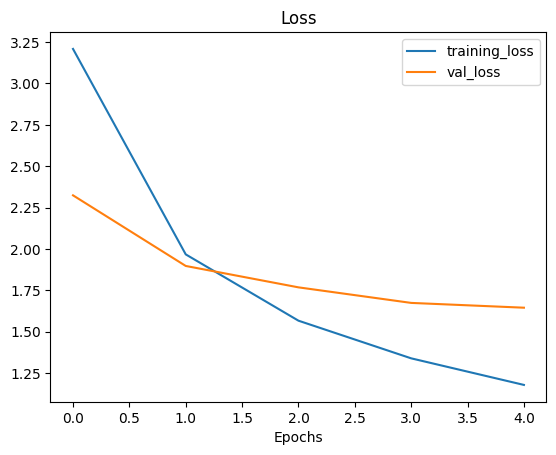

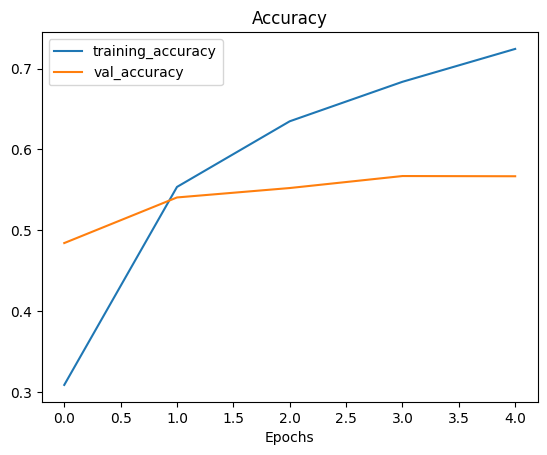

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

### Fine Tuning

In [17]:
# Unfreeze all layers

base_model.trainable = True

# Freeze last 5 layers

for layer in base_model.layers[:-5]:
    layer.trainable = False

In [11]:
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])


In [18]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                      validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 70s 291ms/step - loss: 1.0555 - accuracy: 0.7531 - val_loss: 1.6810 - val_accuracy: 0.5588
Epoch 6/10
237/237 [==============================] - 65s 272ms/step - loss: 0.9480 - accuracy: 0.7831 - val_loss: 1.6963 - val_accuracy: 0.5527
Epoch 7/10
237/237 [==============================] - 60s 253ms/step - loss: 0.8588 - accuracy: 0.8040 - val_loss: 1.7146 - val_accuracy: 0.5487
Epoch 8/10
237/237 [==============================] - 55s 231ms/step - loss: 0.7903 - accuracy: 0.8222 - val_loss: 1.6737 - val_accuracy: 0.5614
Epoch 9/10
237/237 [==============================] - 55s 230ms/step - loss: 0.7210 - accuracy: 0.8442 - val_loss: 1.6985 - val_accuracy: 0.5591
Epoch 10/10
237/237 [==============================] - 50s 210ms/step - loss: 0.6662 - accuracy: 0.8558 - val_loss: 1.6697 - val_accuracy: 0.5654


In [19]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 58s 74ms/step - loss: 1.4233 - accuracy: 0.6160


* We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.

* But metrics schmetrics, let's dive a little deeper into our model's performance and get some visualizations going.



In [20]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip


--2024-02-17 13:29:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  14.0MB/s    in 3.2s    

2024-02-17 13:29:09 (14.0 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [21]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [24]:
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [25]:
results_downloaded_model = model.evaluate(test_data)

790/790 [==============================] - 56s 69ms/step - loss: 1.8027 - accuracy: 0.6078


### Making predictions with our trained model

In [26]:
preds_probs = model.predict(test_data, verbose = 1)

790/790 [==============================] - 60s 74ms/step


In [27]:
len(preds_probs)

25250

In [28]:
# Shape of our predictions
preds_probs.shape

(25250, 101)

In [30]:
pred_classes = preds_probs.argmax(axis = 1)

pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [31]:
# To get our test labels we need to unravel our test_data

y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

* Specifically, it'll:

* Read in a target image filepath using tf.io.read_file().
* Turn the image into a Tensor using tf.io.decode_image().
* Resize the image to be the same size as the images our model has been trained on (224 x 224) using tf.image.resize().
* Scale the image to get all the pixel values between 0 & 1 if necessary.

In [33]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img


In [ ]:
# Make preds on a series of random images
import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);
